In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Data

In [2]:
# Load CFashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=10, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=10, shuffle=False)

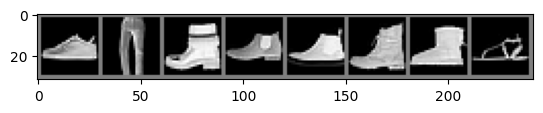

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

#### Model

In [4]:
model = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
model = model.to(device)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=10, bias=True)
)


In [5]:
# Generating a random tensor
input_tensor = torch.rand(5, 28, 28).to(device)

# Feeding the tensor into the model
output = model(input_tensor)
print(output.shape)

torch.Size([5, 10])


#### Loss, Optimizer, and Evaluation Function

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [7]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [8]:
test_loss, test_accuracy = evaluate(model, testloader, criterion)
print(f'test_loss: {test_loss}')
print(f'test_accuracy: {test_accuracy}')

test_loss: 2.3039294242858888
test_accuracy: 10.0


#### Train

In [9]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 400

In [10]:
# train
for epoch in range(max_epoch):
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()        

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/400], Loss: 2.3026, Accuracy: 10.00%, Test Loss: 2.3013, Test Accuracy: 10.00%
Epoch [2/400], Loss: 2.3000, Accuracy: 10.00%, Test Loss: 2.2987, Test Accuracy: 10.00%
Epoch [3/400], Loss: 2.2974, Accuracy: 10.00%, Test Loss: 2.2961, Test Accuracy: 10.00%
Epoch [4/400], Loss: 2.2947, Accuracy: 10.00%, Test Loss: 2.2934, Test Accuracy: 10.00%
Epoch [5/400], Loss: 2.2919, Accuracy: 10.00%, Test Loss: 2.2906, Test Accuracy: 10.00%
Epoch [6/400], Loss: 2.2890, Accuracy: 10.00%, Test Loss: 2.2875, Test Accuracy: 10.00%
Epoch [7/400], Loss: 2.2858, Accuracy: 10.00%, Test Loss: 2.2842, Test Accuracy: 10.00%
Epoch [8/400], Loss: 2.2823, Accuracy: 10.01%, Test Loss: 2.2805, Test Accuracy: 10.10%
Epoch [9/400], Loss: 2.2784, Accuracy: 11.12%, Test Loss: 2.2764, Test Accuracy: 13.06%
Epoch [10/400], Loss: 2.2740, Accuracy: 15.13%, Test Loss: 2.2718, Test Accuracy: 16.83%
Epoch [11/400], Loss: 2.2691, Accuracy: 17.85%, Test Loss: 2.2665, Test Accuracy: 18.42%
Epoch [12/400], Loss: 2.2634, 

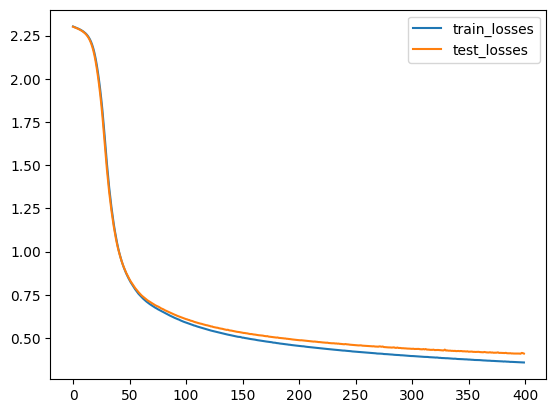

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

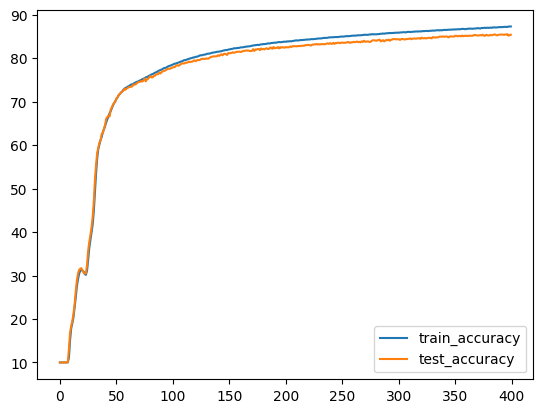

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()